In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_ANIMAL10_TRAIN = Path("/kaggle/input/animal-10/splitData/Train")
PROCESSED_DATASET_PATH_ANIMAL10_TEST = Path("/kaggle/input/animal-10/splitData/Test")
PROCESSED_DATASET_PATH_ANIMAL10_VAL = Path("/kaggle/input/animal-10/splitData/Validation")

# PRETRAINED_MODEL = "/kaggle/input/modele2/e2.pth"

print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_TEST, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)
print(val_set)


14676 2094 4199 ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Dataset ImageFolder
    Number of datapoints: 2094
    Root location: /kaggle/input/animal-10/splitData/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


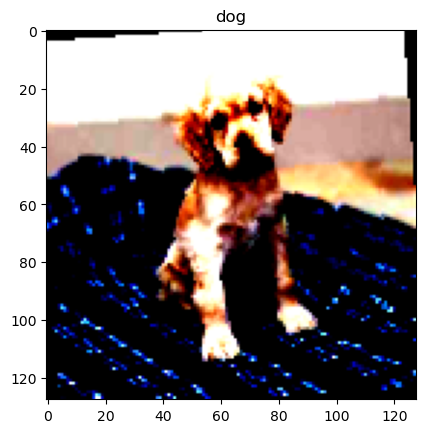

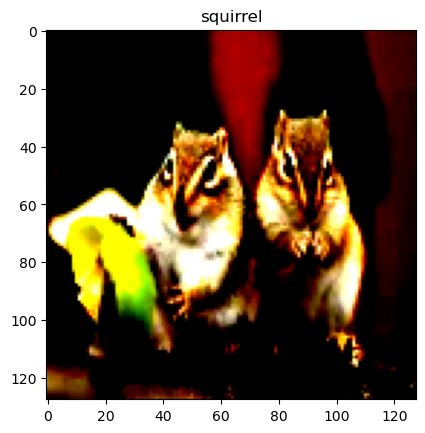

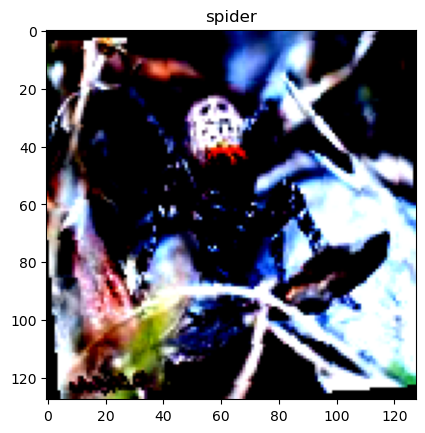

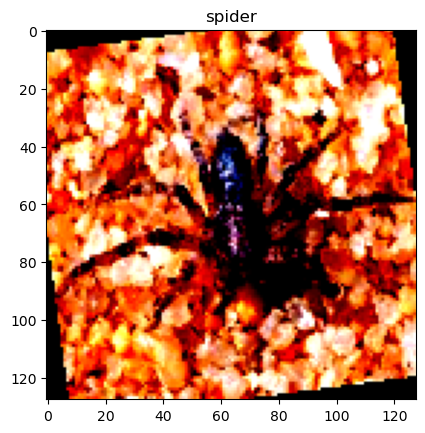

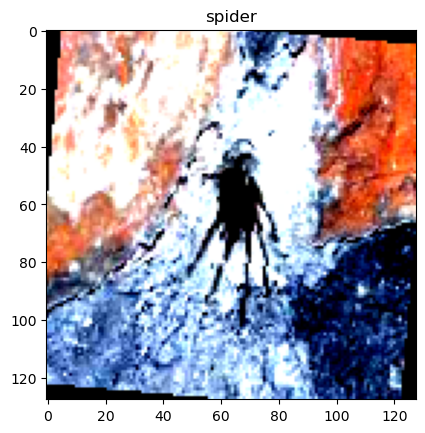

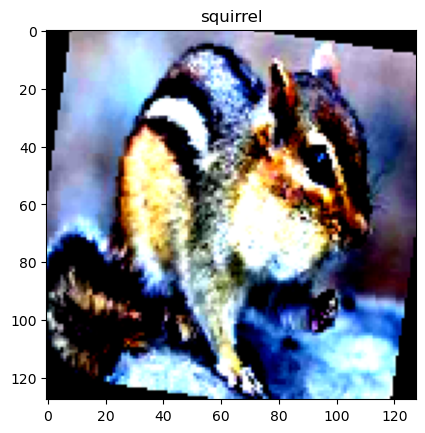

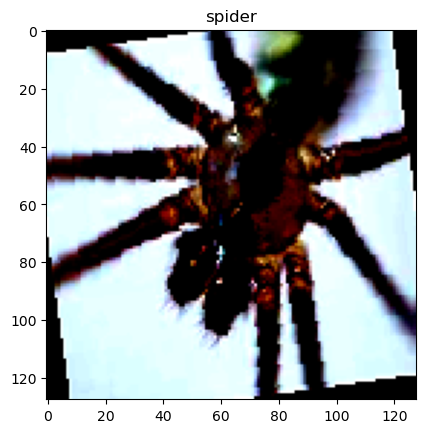

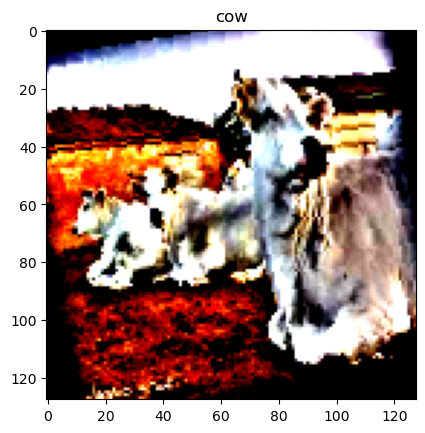

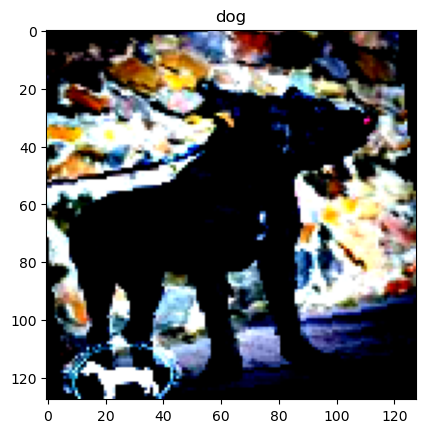

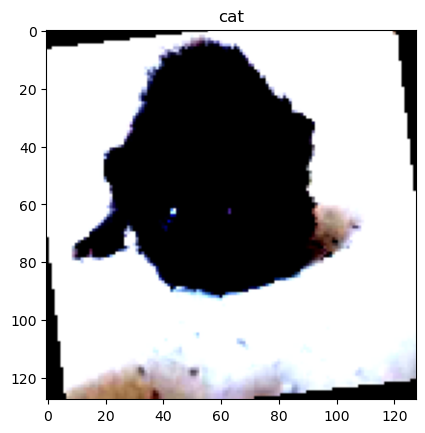

8


In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()
print(len(train_set.classes))

In [4]:
print("Unique classes number : ",len(train_set.classes))
print("Classes : ", train_set.classes)

Unique classes number :  8
Classes :  ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [5]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
model = models.vgg11(num_classes=len(train_set.classes),pretrained=False)
model = model.to(device)
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [6]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
import os
os.makedirs("/kaggle/working/mods")

In [8]:
import pandas as pd
open("/kaggle/working/logs.csv", "a", newline="")
log_file = open("/kaggle/working/logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    try:
        if mode == 'train':
            model.train()
        elif mode == 'val':
            model.eval()

        loss = correct = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)

            if mode == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            loss += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
        loss = loss/len(dataset)
        accuracy = correct/len(dataset)
        return loss, accuracy
    except:
        pass

result_df = pd.DataFrame(columns=['epoch', 'train_loss','train_acc','val_loss','val_acc'])
result_list = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    try:
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        row_dict = {'epoch':epoch,'train_loss':float(train_cost),'train_acc':train_score,'val_loss':float(test_cost),'val_acc':test_score} 
        result_list.append(row_dict)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"/kaggle/working/mods/_e{epoch}.pth")
    except:
        pass
result_df = pd.DataFrame.from_dict(result_list)

Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

1 0.0005803610547445714 0.223221586263287 0.01223834976553917 0.23209169054441262


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

2 0.0006212188163772225 0.23453257018261106 0.013208424672484398 0.23209169054441262


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

3 0.0004949009162373841 0.2282638321068411 0.013801384717226028 0.23209169054441262


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

4 0.0007396132568828762 0.2333060779503952 0.014666353352367878 0.23018147086914995


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

5 0.0006550332182087004 0.22785500136276915 0.01349804736673832 0.23209169054441262


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

6 0.0005800796789117157 0.23126192423003544 0.013488993979990482 0.23018147086914995


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

7 0.0006843089940957725 0.23160261651676206 0.013354678638279438 0.23209169054441262


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

8 0.0007374671404249966 0.23010357045516489 0.013235017657279968 0.23018147086914995


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

9 0.0005905568832531571 0.2317388934314527 0.01406677346676588 0.23018147086914995


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

10 0.000752387335523963 0.2324884164622513 0.014886307530105114 0.23018147086914995


In [ ]:
# import shutil
# shutil.make_archive('/kaggle/working/', 'zip', 'Output-Animal10')

In [9]:
BATCH_SIZE = 10


PRETRAINED_MODEL = "/kaggle/working/mods/_e8.pth"

In [10]:
result_df

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.000580,0.223222,0.012238,0.232092
1,2,0.000621,0.234533,0.013208,0.232092
2,3,0.000495,0.228264,0.013801,0.232092
3,4,0.000740,0.233306,0.014666,0.230181
4,5,0.000655,0.227855,0.013498,0.232092
5,6,0.000580,0.231262,0.013489,0.230181
6,7,0.000684,0.231603,0.013355,0.232092
7,8,0.000737,0.230104,0.013235,0.230181
8,9,0.000591,0.231739,0.014067,0.230181
9,10,0.000752,0.232488,0.014886,0.230181


In [11]:
testset = torchvision.datasets.ImageFolder( PROCESSED_DATASET_PATH_ANIMAL10_TEST,transform = transforms)
testloader = torch.utils.data.DataLoader(testset  , batch_size=BATCH_SIZE)

In [12]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.vgg11(num_classes=len(testset.classes),pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

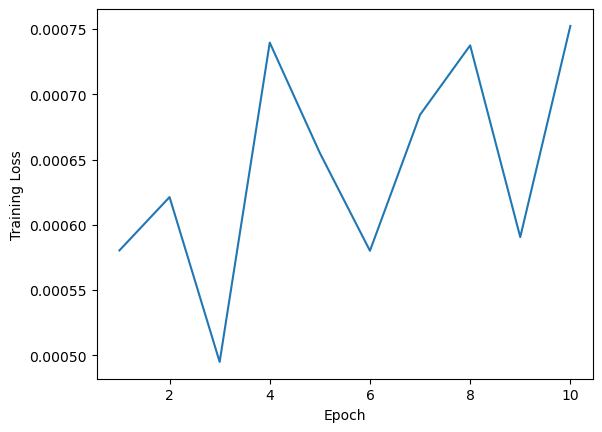

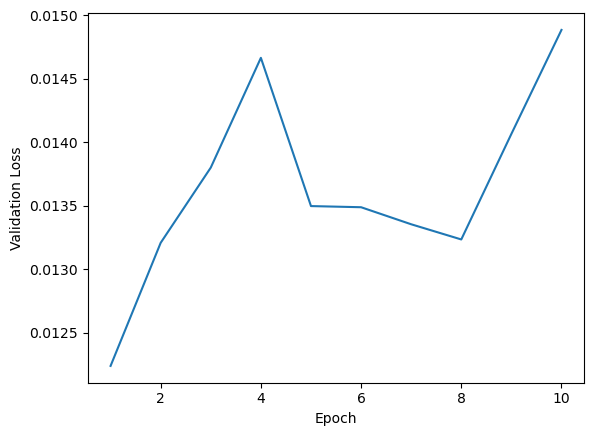

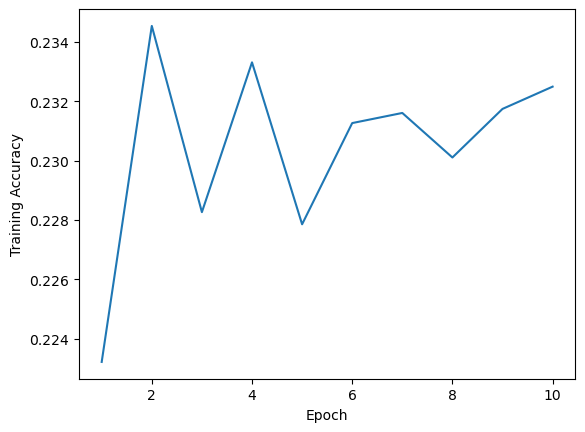

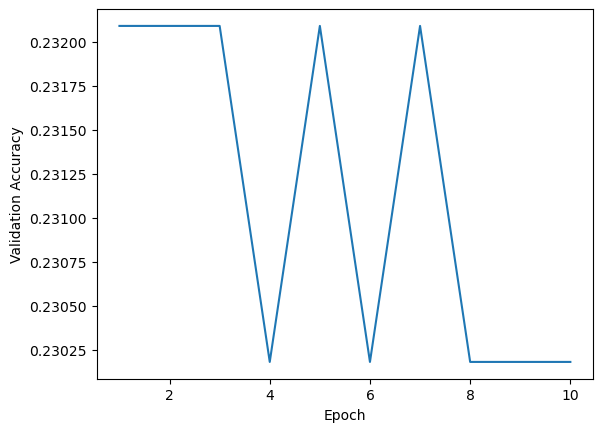

In [13]:
import pandas as pd

# df = pd.read_csv("../input/animal10csv/Mobilenet.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(result_df["epoch"], result_df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(result_df["epoch"], result_df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(result_df["epoch"], result_df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(result_df["epoch"], result_df["val_acc"])
plt.show()

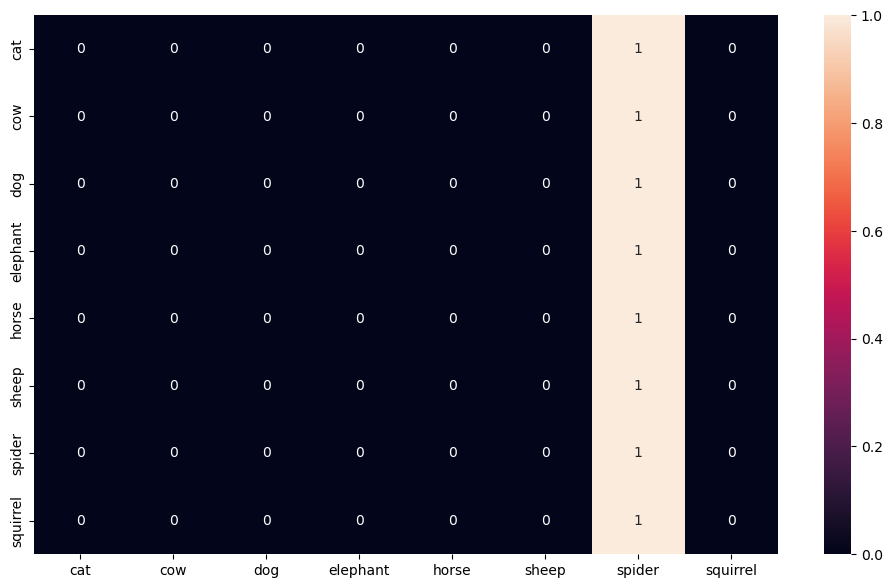

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

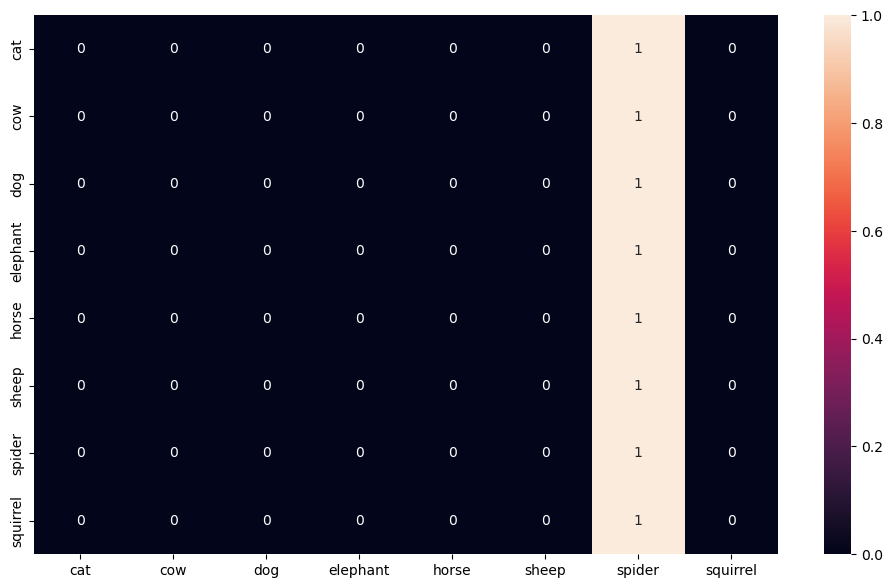

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [16]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=testset.classes))

Overall Accuracy:  22.98  %
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00       335
         cow       0.00      0.00      0.00       374
         dog       0.00      0.00      0.00       973
    elephant       0.00      0.00      0.00       290
       horse       0.00      0.00      0.00       525
       sheep       0.00      0.00      0.00       364
      spider       0.23      1.00      0.37       965
    squirrel       0.00      0.00      0.00       373

    accuracy                           0.23      4199
   macro avg       0.03      0.12      0.05      4199
weighted avg       0.05      0.23      0.09      4199



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
